# Motzkin

**Adapted from**: (3.6) and (3.19) of [BPT12]

[BPT12] Blekherman, G.; Parrilo, P. A. & Thomas, R. R.
*Semidefinite Optimization and Convex Algebraic Geometry*.
Society for Industrial and Applied Mathematics, **2012**.

The first explicit example of nonnegative polynomial that is not a sum of squares was found by Motzkin in 1967. By the [Arithmetic-geometric mean](https://en.wikipedia.org/wiki/Arithmetic%E2%80%93geometric_mean),
$$ \frac{x^4y^2 + x^2y^4 + 1}{3} \ge \sqrt[3]{x^4y^2 \cdot x^2y^4 \cdot 1} = x^2y^2 $$
hence
$$ x^4y^2 + x^2y^4 + 1 - 3x^2y^2 \ge 0. $$
The code belows construct the Motzkin polynomial using [DynamicPolynomials](https://github.com/JuliaAlgebra/DynamicPolynomials.jl).

In [1]:
using DynamicPolynomials
@polyvar x y
motzkin = x^4*y^2 + x^2*y^4 + 1 - 3x^2*y^2

x⁴y² + x²y⁴ - 3x²y² + 1

The Motzkin polynomial is nonnegative but is not a sum of squares as we can verify numerically as follows.
We first need to pick an SDP solver, see [here](https://jump.dev/JuMP.jl/v1.8/installation/#Supported-solvers) for a list of the available choices.

In [2]:
using SumOfSquares
import CSDP
solver = optimizer_with_attributes(CSDP.Optimizer, MOI.Silent() => true)
model = SOSModel(solver)
@constraint(model, motzkin >= 0) # We constraint `motzkin` to be a sum of squares

optimize!(model)

We see that the problem is detected as infeasible...

In [3]:
termination_status(model)

INFEASIBLE::TerminationStatusCode = 2

... and that the dual solution is a certificate of the infeasibility of the problem.

In [4]:
dual_status(model)

INFEASIBILITY_CERTIFICATE::ResultStatusCode = 4

Even if the Motzkin polynomial is not a sum of squares, it can still be certified to be nonnegative using sums of squares.
Indeed a polynomial is certified to be nonnegative if it is equal to a fraction of sums of squares.
The Motzkin polynomial is equal to a fraction of sums of squares whose denominator is $x^2 + y^2$.
This can be verified numerically as follows:

In [5]:
model = SOSModel(solver)
@constraint(model, (x^2 + y^2) * motzkin >= 0) # We constraint the `(x^2 + y^2) * motzkin` to be a sum of squares

optimize!(model)

Now the problem is declared feasible by the solver...

In [6]:
termination_status(model)

OPTIMAL::TerminationStatusCode = 1

... and the primal solution is a feasible point, hence it is a certificate of nonnegativity of the Motzkin polynomial.

In [7]:
primal_status(model)

FEASIBLE_POINT::ResultStatusCode = 1

One may consider ourself lucky to have had the intuition that $x^2 + y^2$ would work as denominator.
In fact, the search for the denominator can be carried out in parallel to the search of the numerator.
In the example below, we search for a denominator with monomials of degrees from 0 to 2.
If none is found, we can increase the maximum degree 2 to 4, 6, 8, ...
This gives a hierarchy of programs to try in order to certify the nonnegativity of a polynomial by identifying it with a fraction of sum of squares polynomials.
In the case of the Motzkin polynomial we now that degree 2 is enough since $x^2 + y^2$ works.

In [8]:
model = SOSModel(solver)
X = monomials([x, y], 0:2)

6-element DynamicPolynomials.MonomialVector{true}:
 x²
 xy
 y²
 x
 y
 1

We create a quadratic polynomial that is not necessarily a sum of squares since this is implied by the next constraint: `deno >= 1`.

In [9]:
@variable(model, deno, Poly(X))

(_[1])x² + (_[2])xy + (_[3])y² + (_[4])x + (_[5])y + (_[6])

We want the denominator polynomial to be strictly positive, this prevents the trivial solution deno = 0 for instance.

In [10]:
@constraint(model, deno >= 1)
@constraint(model, deno * motzkin >= 0)
optimize!(model)

termination_status(model)

primal_status(model)

FEASIBLE_POINT::ResultStatusCode = 1

We can check the denominator found by the program using `JuMP.value`

In [11]:
value(deno)

12.292628687208005x² + 12.292628753109426y² + 23.251596478120113

Because a picture is worth a thousand words let's plot the beast.
We can easily extend `Plots` by adding a recipe to plot bivariate polynomials.

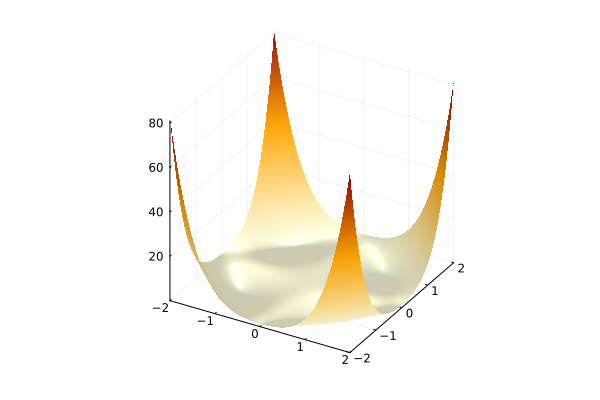

In [12]:
using RecipesBase
@recipe function f(x::AbstractVector, y::AbstractVector, p::Polynomial)
    x, y, (x, y) -> p(variables(p) => [x, y])
end
import Plots
Plots.plot(
    range(-2, stop=2, length=100),
    range(-2, stop=2, length=100),
    motzkin,
    st = [:surface],
    seriescolor=:heat,
    colorbar=:none,
    clims = (-10, 80)
)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*